# 作业三：实战CNN —— CIFAR-10图像分类


| 姓名 | 学号 |
| :--: | :--: |
| 艾华喜 | 1120222907 |


### 要求：

<font color=Red>完成以下notebook，CIFAR数据集的下载和处理代码已经给出，请同学们自行完成训练过程。作业提交 jupyter notebook 文件。</font>

CIFAR-10 是由 Hinton 的学生 Alex Krizhevsky 和 Ilya Sutskever 整理的一个用于识别普适物体的小型数据集。

一共包含 10 个类别的 RGB 彩色图 片：飞机（ airlane ）、汽车（ automobile ）、鸟类（ bird ）、猫（ cat ）、鹿（ deer ）、狗（ dog ）、蛙类（ frog ）、马（ horse ）、船（ ship ）和卡车（ truck ）。图片的尺寸为 32×32 ，数据集中一共有 50000 张训练圄片和 10000 张测试图片。

## 下载和缓存数据集

这里实现了几个函数来下载 CIFAR-10 数据集， CIFAR_URL是下载数据集的网址。

In [8]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
import time
import shutil
import requests
import random


CIFAR_URL = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'

下面的`download`函数用来下载并解压缩数据集，
将数据集缓存在本地目录（默认情况下为`../data`）中。
如果缓存目录中已经存在此数据集文件，并且其名称与下载文件名匹配，
我们将使用缓存的文件，以避免重复的下载。

下载完成后函数执行解压缩，为避免重复解压缩，同样检查是否有文件名相匹配。

In [9]:
def downloadCIFAR():
    if not os.path.exists('../data'):
        os.makedirs('../data')  # 使用os.makedirs()创建目录
        print('Created directory')

    if not os.path.exists('../data/cifar-10-python.tar.gz'):
        print('Downloading CIFAR')
        response = requests.get(CIFAR_URL, stream=True)
        if response.status_code == 200:
            with open("cifar-10-python.tar.gz", 'wb') as f:
                response.raw.decode_content = True
                shutil.copyfileobj(response.raw, f)
            shutil.move("cifar-10-python.tar.gz", "../data/cifar-10-python.tar.gz")
            print('CIFAR downloaded')
        else:
            print('Failed to download CIFAR')
            return

    if not os.path.exists('../data/cifar-10-batches-py'):
        print('Unpacking CIFAR')
        os.system('tar -zxvf ../data/cifar-10-python.tar.gz -C ../data/')
        print('CIFAR unpacked')
    else:
        print('CIFAR already unpacked')


downloadCIFAR()

CIFAR already unpacked


## 数据处理

下面的代码用作处理数据。
 
CIFAR数据保存为 `pkl` 格式，需要加载 `pickle` 来读取文件，下面的 `unpickle` 函数实现了读取 `pkl` 文件并返回 `List` 的功能。

可以尝试展示一下读取的数据，下面的 `show_img` 函数实现了读取数据并展示图片和label的功能

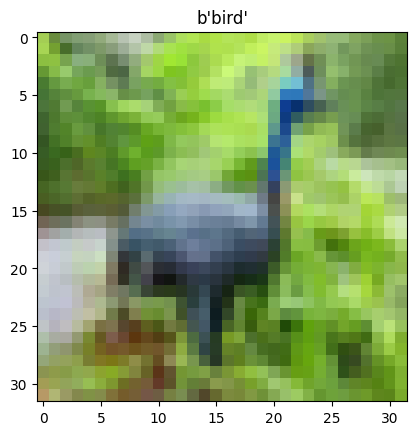

In [10]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


def show_img(num):
    dict = unpickle('../data/cifar-10-batches-py/data_batch_1')
    info = unpickle('../data/cifar-10-batches-py/batches.meta')
    np_img = dict[b'data'][num].reshape([3, 32, 32])
    np_img = np_img.transpose(1, 2, 0)
    label = info[b'label_names'][dict[b'labels'][num]]
    
    plt.imshow(np_img)
    plt.axis('on')
    plt.title(label)
    plt.show()

    
show_img(6)

下面的代码实现了将读取到的数据转为torch.tensor以及一系列形状操作。

<font color=Red>完成作业时可以参考下面的代码，也可以自己实现相关功能。<font>

In [11]:
def get_label_data(train_val, num=0):
    if train_val == 'train':
        dict = unpickle('../data/cifar-10-batches-py/data_batch_{}'.format(num))
        return torch.tensor(dict[b'labels'], dtype=torch.long), torch.tensor(dict[b'data'], 
                                                                                dtype=torch.float32).reshape(10000, 3, 32, 32)
    else:
        dict = unpickle('../data/cifar-10-batches-py/test_batch')
        return torch.tensor(dict[b'labels'], dtype=torch.long), torch.tensor(dict[b'data'], 
                                                                                dtype=torch.float32).reshape(10000, 3, 32, 32)

def load_data():
    for i in range(5):
        if i == 0:
            train_labels, train_data = get_label_data('train', i + 1)
        else:
            res = get_label_data('train', i + 1)
            train_labels = torch.concat((train_labels, res[0]), dim=0)
            train_data = torch.concat((train_data, res[1]), dim=0)
    test_labels, test_data = get_label_data('test')
    return train_labels, train_data, test_labels, test_data

train_labels, train_data, test_labels, test_data = load_data()
print(train_labels.shape, train_data.shape, test_labels.shape, test_data.shape)

torch.Size([50000]) torch.Size([50000, 3, 32, 32]) torch.Size([10000]) torch.Size([10000, 3, 32, 32])


# <font color=Red>训练（自行完成）<font>

看到这里，请同学自己完成从**定义data loader、定义网络、定义损失函数、定义优化器到进行训练等一系列深度学习流水线**。
    
神经网络请使用 ***卷积神经网络*** ，可以使用现有论文模型，也可以自己提出改进或提出新模型。

不限制手写或使用 `torch.nn`等高级API，视手写代码占比有一定程度加分（最多加1分）。

In [12]:
import torch
import random
import time
import numpy as np

def date_iter(batch_size, features, labels):
    """生成训练过程中的数据批次。"""
    num_examples = len(features)
    indices = list(range(num_examples))
    # 随机打乱索引，以进行无放回的随机抽样
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

# 检查GPU是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义卷积核张量 K1 和 K2
K1 = torch.randn(6, 3, 5, 5, requires_grad=True, device=device)
K2 = torch.randn(16, 6, 5, 5, requires_grad=True, device=device)

# 定义全连接层权重张量 w1、w2、w3
w1 = torch.normal(0, 0.001, (576, 120), requires_grad=True, device=device)
w2 = torch.normal(0, 0.001, (120, 84), requires_grad=True, device=device)
w3 = torch.normal(0, 0.001, (84, 10), requires_grad=True, device=device)

# 定义偏置张量 b1、b2、b3
b1 = torch.normal(0, 0.001, (120,), requires_grad=True, device=device)
b2 = torch.normal(0, 0.001, (84,), requires_grad=True, device=device)
b3 = torch.normal(0, 0.001, (10,), requires_grad=True, device=device)

def corr2d(X, K, padding_rows=0, padding_cols=0):
    """计算二维互相关运算。"""
    co, ci, h, w = K.shape
    x_padded = torch.zeros(X.shape[0], X.shape[1], X.shape[2] + 2 * padding_rows, X.shape[3] + 2 * padding_cols,
                           device=device)
    if padding_rows > 0:
        x_padded[:, :, padding_rows:-padding_rows, padding_cols:-padding_cols] = X
    else:
        x_padded[:, :, :, :] = X
    Y = torch.zeros(X.shape[0], co, x_padded.shape[2] - h + 1, x_padded.shape[3] - w + 1, device=device)
    x_shaped = x_padded.reshape(x_padded.shape[0], 1, x_padded.shape[1], x_padded.shape[2], x_padded.shape[3])
    for i in range(Y.shape[2]):
        for j in range(Y.shape[3]):
            Y[:, :, i, j] = (x_shaped[:, :, :, i:i + h, j:j + w] * K).sum(dim=(2, 3, 4))
    return Y

def pool2d(X, pool_size, stride, mode='max'):
    """二维池化操作。"""
    p_h, p_w = pool_size
    Y = torch.zeros(
        (X.shape[0], X.shape[1], int((X.shape[2] - p_h) / stride) + 1, int((X.shape[3] - p_w) / stride) + 1),
        device=device)
    for i in range(Y.shape[2]):
        for j in range(Y.shape[3]):
            if mode == 'max':
                Y[:, :, i, j] = \
                X[:, :, i * stride: i * stride + p_h, j * stride: j * stride + p_w].max(dim=3)[0].max(dim=2)[0]
            elif mode == 'avg':
                Y[:, :, i, j] = \
                X[:, :, i * stride: i * stride + p_h, j * stride: j * stride + p_w].mean(dim=3)[0].max(dim=2)[0]
    return Y

def relu(X):
    """ReLU 激活函数。"""
    a = torch.zeros_like(X)
    return torch.max(X, a)

def sigmoid(X):
    """Sigmoid 激活函数。"""
    return 1 / (1 + torch.exp(-X))

def net(X):
    """定义神经网络架构。"""
    y1 = corr2d(X, K1, 2, 2)
    y2 = relu(y1)
    y3 = pool2d(y2, (2, 2), 2)
    y4 = corr2d(y3, K2)
    y5 = relu(y4)
    y6 = pool2d(y5, (2, 2), 2)
    y7 = y6.view(y6.size(0), -1)
    y8 = y7 @ w1 + b1
    y9 = relu(y8)
    y10 = y9 @ w2 + b2
    y11 = relu(y10)
    y12 = y11 @ w3 + b3
    return y12

def softmax(X):
    """Softmax 激活函数。"""
    x_max = torch.max(X, dim=1, keepdim=True)[0]
    x1 = X - x_max
    X_exp = torch.exp(x1)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition

def cross_entropy(X, y):
    """交叉熵损失函数。"""
    x_max = torch.max(X, dim=1, keepdim=True)[0]
    x1 = X - x_max
    X_exp = torch.exp(x1)
    partition = X_exp.sum(1, keepdim=True)
    y1 = torch.log(partition)
    y2 = y1 - x1
    loss = y2[range(len(y2)), y]
    return loss.mean()

class Accumulator:
    """用于累加 `n` 个变量的累加器。"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)

def accuracy(y_hat, y):
    """计算正确预测的数量。"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = argmax(y_hat, axis=1)
    cmp = astype(y_hat, y.dtype) == y
    return float(reduce_sum(astype(cmp, y.dtype)))

def evaluate_accuracy_gpu(net, loss_fn):
    """评估模型在数据集上的准确性。"""
    metric = Accumulator(3)
    with torch.no_grad():
        for X, y in date_iter(batch_size, train_data, train_labels):
            if isinstance(X, list):
                # 对于BERT微调等情况（稍后介绍），可能需要使用列表
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss_fn(y_hat, y)
            metric.add(l * X.shape[0], accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

class Timer:
    """记录多个运行时间的计时器。"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器。"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中。"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间。"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回总时间。"""
        return sum(self.times)

    def cumsum(self):
        """返回累积时间。"""
        return np.array(self.times).cumsum().tolist()

def train(model, optimizer, loss_fn, train_ds, test_ds, num_epochs, device):
    """训练函数。"""
    timer = Timer()
    print("Training")
    train_l_array = []
    train_acc_array = []
    test_acc_array = []
    test_l_array = []
    for epoch in range(num_epochs):
        metric = Accumulator(3)
        for i, (X, y) in enumerate(date_iter(batch_size, train_ds, test_ds)):
            timer.start()
            optimizer.zero_grad()
            X = X.to(device)
            y = y.to(device)
            y_hat = model(X)
            l = loss_fn(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]

        test_l, test_acc = evaluate_accuracy_gpu(net, loss_fn)
        train_l_array.append(train_l)
        train_acc_array.append(train_acc)
        test_l_array.append(test_l)
        test_acc_array.append(test_acc)
        print(f'Epoch  {epoch + 1}/{num_epochs}  loss {train_l:.3f}, train acc {train_acc:.3f}, '
              f'test acc {test_acc:.3f}, {metric[2] * num_epochs / timer.sum():.1f} examples/sec on {str(device)}')
    return train_l_array, train_acc_array, test_acc_array, test_l_array


## 提示

卷积神经网络和线性回归以及多层感知机相比训练时间可能稍微会有点长，建议使用GPU训练。

## 训练结果

请将训练的 loss 下降过程以及 acc 打印出来，并展示在下方

In [13]:
loss=cross_entropy
lr = 0.001
num_epochs = 40
updater = torch.optim.Adam([K1,K2, w1,w2,w3, b1, b2, b3], lr=lr)
batch_size = 256
clk=train(net,updater,loss,train_data,train_labels,num_epochs,device)

Trainning
Epoch  1/40  loss 1.957, train acc 0.255, test acc 0.352, 20994.4 examples/sec on cuda
Epoch  2/40  loss 1.675, train acc 0.370, test acc 0.381, 10509.4 examples/sec on cuda
Epoch  3/40  loss 1.627, train acc 0.389, test acc 0.403, 7025.6 examples/sec on cuda
Epoch  4/40  loss 1.597, train acc 0.402, test acc 0.415, 5281.0 examples/sec on cuda
Epoch  5/40  loss 1.577, train acc 0.410, test acc 0.417, 4231.2 examples/sec on cuda
Epoch  6/40  loss 1.548, train acc 0.425, test acc 0.439, 3534.1 examples/sec on cuda
Epoch  7/40  loss 1.542, train acc 0.425, test acc 0.425, 3034.5 examples/sec on cuda
Epoch  8/40  loss 1.531, train acc 0.432, test acc 0.430, 2656.0 examples/sec on cuda
Epoch  9/40  loss 1.517, train acc 0.436, test acc 0.442, 2357.5 examples/sec on cuda
Epoch  10/40  loss 1.507, train acc 0.444, test acc 0.449, 2117.9 examples/sec on cuda
Epoch  11/40  loss 1.497, train acc 0.444, test acc 0.451, 1924.4 examples/sec on cuda
Epoch  12/40  loss 1.492, train acc 0.44

可以尝试画出 loss 和 acc 变动的曲线。

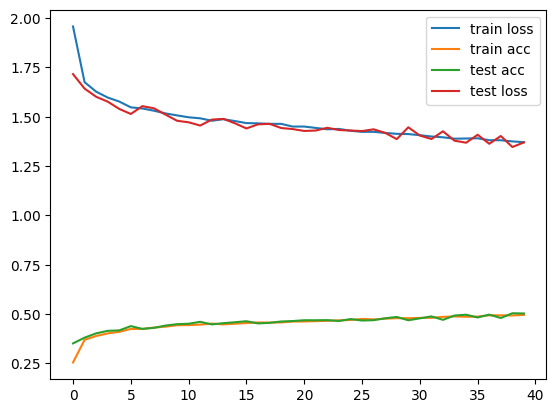

In [14]:
# 绘图代码
epochs_array=[i for i in range(num_epochs)]
plt.plot(epochs_array, clk[0], label='train loss')
plt.plot(epochs_array, clk[1], label='train acc')
plt.plot(epochs_array, clk[2], label='test acc')
plt.plot(epochs_array, clk[3], label='test loss')

plt.legend()

plt.show()

## 提交方式
<font color=Red>包含运行结果的Jupyter notebook文件请命名为 `work3_<姓名>_<学号>.ipynb` 提交到乐学平时小作业3中</font>